Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [43]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math

from sklearn import preprocessing
import datetime

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [44]:
os.environ["CUDA_VISIBLE_DEVICES"]="3"

strategy = tf.distribute.MirroredStrategy(["GPU:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [45]:
df = pd.read_csv('Label_Training.csv')
df

,video_num,filename,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/246...
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/094...
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/158...
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/062...
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/174...
...,...,...,...,...,...,...
7015,35,177.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/17...
7016,35,066.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/06...
7017,35,042.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/04...
7018,35,250.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/25...


,video_num,filename,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/246...
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/094...
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/158...
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/062...
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/174...
...,...,...,...,...,...,...
7015,35,177.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/17...
7016,35,066.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/06...
7017,35,042.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/04...
7018,35,250.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/25...


In [46]:
test = df[(df['patient']==7)]
test

,video_num,filename,infection,patient,class_label,image_path
2340,18,246.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/24...
2341,18,094.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/09...
2342,18,158.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/15...
2343,18,062.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/06...
2344,18,174.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/17...
...,...,...,...,...,...,...
3115,20,177.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/17...
3116,20,066.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/06...
3117,20,042.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/04...
3118,20,250.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/25...


,video_num,filename,infection,patient,class_label,image_path
2340,18,246.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/24...
2341,18,094.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/09...
2342,18,158.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/15...
2343,18,062.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/06...
2344,18,174.tif,ca,7,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/18/17...
...,...,...,...,...,...,...
3115,20,177.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/17...
3116,20,066.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/06...
3117,20,042.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/04...
3118,20,250.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/25...


In [47]:
Xtrain = pd.concat([df, test]).drop_duplicates(keep=False)
Xtrain

,video_num,filename,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/246...
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/094...
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/158...
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/062...
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/174...
...,...,...,...,...,...,...
7015,35,177.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/17...
7016,35,066.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/06...
7017,35,042.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/04...
7018,35,250.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/25...


,video_num,filename,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/246...
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/094...
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/158...
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/062...
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/174...
...,...,...,...,...,...,...
7015,35,177.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/17...
7016,35,066.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/06...
7017,35,042.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/04...
7018,35,250.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/25...


In [48]:
train, val = train_test_split(Xtrain, test_size=0.2, stratify = Xtrain['class_label'], random_state=42)
train

,video_num,filename,infection,patient,class_label,image_path
542,3,186.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/3/186...
3459,22,178.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/22/17...
3528,22,107.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/22/10...
888,4,142.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/142...
4519,26,197.tif,mock,9,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/26/19...
...,...,...,...,...,...,...
2231,15,140.tif,mock,5,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/15/14...
902,4,189.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/189...
6588,34,115.tif,cg,12,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/34/11...
4264,25,179.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/25/17...


,video_num,filename,infection,patient,class_label,image_path
542,3,186.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/3/186...
3459,22,178.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/22/17...
3528,22,107.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/22/10...
888,4,142.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/142...
4519,26,197.tif,mock,9,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/26/19...
...,...,...,...,...,...,...
2231,15,140.tif,mock,5,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/15/14...
902,4,189.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/189...
6588,34,115.tif,cg,12,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/34/11...
4264,25,179.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/25/17...


In [49]:
val

,video_num,filename,infection,patient,class_label,image_path
5852,31,069.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/31/06...
6462,33,056.tif,ca,12,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/33/05...
1273,5,233.tif,cg,2,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/5/233...
3211,21,051.tif,ca,8,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/21/05...
926,4,039.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/039...
...,...,...,...,...,...,...
3924,24,098.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/24/09...
5908,31,103.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/31/10...
4352,25,072.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/25/07...
3929,24,161.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/24/16...


,video_num,filename,infection,patient,class_label,image_path
5852,31,069.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/31/06...
6462,33,056.tif,ca,12,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/33/05...
1273,5,233.tif,cg,2,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/5/233...
3211,21,051.tif,ca,8,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/21/05...
926,4,039.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/039...
...,...,...,...,...,...,...
3924,24,098.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/24/09...
5908,31,103.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/31/10...
4352,25,072.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/25/07...
3929,24,161.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/24/16...


In [50]:
image_size = 512
batch_size = 16

def get_train_generator(df, x_col, y_cols, shuffle=True, batch_size=batch_size, seed=1, image_size=image_size):

    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size=(image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, x_col, y_cols, batch_size=batch_size, seed=1, image_size=image_size):

    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

In [51]:
train_generator = get_train_generator(train, 'image_path', 'class_label')
valid_generator, test_generator= get_test_and_valid_generator(val, test, 'image_path','class_label')

Found 4992 validated image filenames.
Found 1248 validated image filenames.
Found 780 validated image filenames.
Found 4992 validated image filenames.
Found 1248 validated image filenames.
Found 780 validated image filenames.


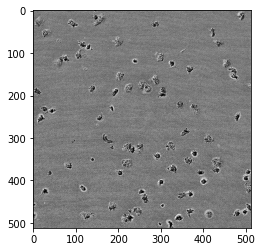

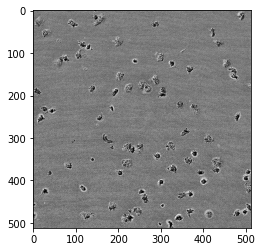

In [52]:
x, y = train_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

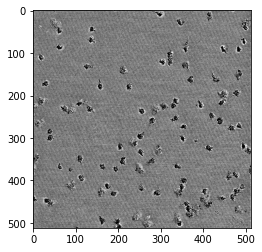

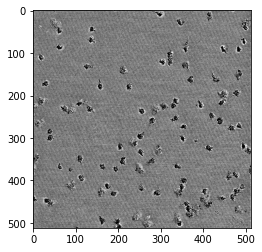

In [53]:
x, y = valid_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

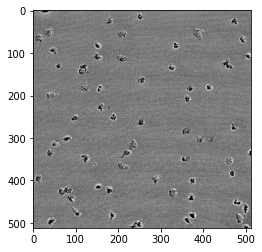

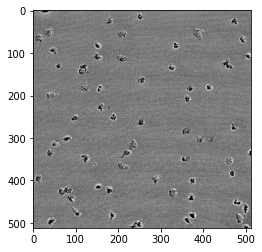

In [54]:
x, y = test_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

In [55]:
with strategy.scope():
    
    inputs = Input(shape=(image_size,image_size, 3))
    base_model = EfficientNetB5 (weights = 'imagenet',include_top=False, input_tensor=inputs)

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)

    x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
    x = Dropout(0.5)(x)

    # and a logistic layer
    predictions = Dense(3, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 512, 512, 3)  0           ['input_3[

 agePooling2D)                                                                                    
                                                                                                  
 block1a_se_reshape (Reshape)   (None, 1, 1, 48)     0           ['block1a_se_squeeze[0][0]']     
                                                                                                  
 block1a_se_reduce (Conv2D)     (None, 1, 1, 12)     588         ['block1a_se_reshape[0][0]']     
                                                                                                  
 block1a_se_expand (Conv2D)     (None, 1, 1, 48)     624         ['block1a_se_reduce[0][0]']      
                                                                                                  
 block1a_se_excite (Multiply)   (None, 256, 256, 48  0           ['block1a_activation[0][0]',     
                                )                                 'block1a_se_expand[0][0]']      
          

                                                                                                  
 block1b_add (Add)              (None, 256, 256, 24  0           ['block1b_drop[0][0]',           
                                )                                 'block1a_project_bn[0][0]']     
                                                                                                  
 block1c_dwconv (DepthwiseConv2  (None, 256, 256, 24  216        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
                                                                                                  
 block1c_bn (BatchNormalization  (None, 256, 256, 24  96         ['block1c_dwconv[0][0]']         
 )                              )                                                                 
          

 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 257, 257, 14  0          ['block2a_expand_activation[0][0]
 g2D)                           4)                               ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 128, 128, 14  1296       ['block2a_dwconv_pad[0][0]']     
 D)                             4)                                                                
                                                                                                  
 block2a_bn (BatchNormalization  (None, 128, 128, 14  576        ['block2a_dwconv[0][0]']         
 )                              4)                                                                
          

                                                                                                  
 block2b_activation (Activation  (None, 128, 128, 24  0          ['block2b_bn[0][0]']             
 )                              0)                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 240)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block2b_se_squeeze[0][0]']     
 block2b_expand_activation (Act  (None, 128, 128, 24  0          ['block2b_expand_bn[0][0]']      
                                                                                                  
 ivation) 

                                0)                                                                
                                                                                                  
 block2c_expand_bn (BatchNormal  (None, 128, 128, 24  960        ['block2c_expand_conv[0][0]']    
 ization)                       0)                                                                
                                                                                                  
 block2c_expand_activation (Act  (None, 128, 128, 24  0          ['block2c_expand_bn[0][0]']      
 ivation)                       0)                                                                
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 128, 128, 24  2160       ['block2c_expand_activation[0][0]
 D)                             0)                               ']                               
          

 ization)                       0)                                                                
                                                                                                  
 block2d_expand_activation (Act  (None, 128, 128, 24  0          ['block2d_expand_bn[0][0]']      
 ivation)                       0)                                                                
                                                                                                  
 block2d_dwconv (DepthwiseConv2  (None, 128, 128, 24  2160       ['block2d_expand_activation[0][0]
 D)                             0)                               ']                               
                                                                                                  
 block2d_bn (BatchNormalization  (None, 128, 128, 24  960        ['block2d_dwconv[0][0]']         
 )                              0)                                                                
          

 ivation)                       0)                                                                
                                                                                                  
 block2e_dwconv (DepthwiseConv2  (None, 128, 128, 24  2160       ['block2e_expand_activation[0][0]
 D)                             0)                               ']                               
                                                                                                  
 D)                             0)                               ']                               
                                                                                                  
 block2e_bn (BatchNormalization  (None, 128, 128, 24  960        ['block2e_dwconv[0][0]']         
 )                              0)                                                                
                                                                                                  
 block2e_a

                                                                                                  
 block3a_dwconv_pad (ZeroPaddin  (None, 131, 131, 24  0          ['block3a_expand_activation[0][0]
 g2D)                           0)                               ']                               
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 64, 64, 240)  6000       ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 64, 64, 240)  960        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_a

 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 384)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 384)    6528        ['block3b_se_reduce[0][0]']      
 block3b_d

                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block3c_se_reshape[0][0]']     
                                                                                                  
                                                                                                  
 block3c_dwconv (DepthwiseConv2  (None, 64, 64, 384)  9600       ['block3c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3c_bn (BatchNormalization  (None, 64, 64, 384)  1536       ['block3c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3c_a

                                                                                                  
 block3d_bn (BatchNormalization  (None, 64, 64, 384)  1536       ['block3d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3d_activation (Activation  (None, 64, 64, 384)  0          ['block3d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3d_se_squeeze (GlobalAver  (None, 384)         0           ['block3d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3d_s

                                                                                                  
 block3e_se_squeeze (GlobalAver  (None, 384)         0           ['block3e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3e_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block3e_se_squeeze[0][0]']     
                                                                                                  
 block3e_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block3e_se_reshape[0][0]']     
                                                                                                  
 block3e_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block3e_se_reshape[0][0]']     
                                                                                                  
 block3e_s

                                                                                                  
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 384)    6528        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 32, 32, 384)  0           ['block4a_activation[0][0]',     
          

                                                                                                  
 block4b_project_conv (Conv2D)  (None, 32, 32, 128)  98304       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 32, 32, 128)  512        ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (Dropout)         (None, 32, 32, 128)  0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 32, 32, 128)  0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
          

 block4c_se_squeeze (GlobalAver  (None, 768)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 32)     24608       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 768)    25344       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 32, 32, 768)  0           ['block4c_activation[0][0]',     
          

 block4d_se_expand (Conv2D)     (None, 1, 1, 768)    25344       ['block4d_se_reduce[0][0]']      
                                                                                                  
 block4d_se_excite (Multiply)   (None, 32, 32, 768)  0           ['block4d_activation[0][0]',     
                                                                  'block4d_se_expand[0][0]']      
                                                                                                  
 block4d_project_conv (Conv2D)  (None, 32, 32, 128)  98304       ['block4d_se_excite[0][0]']      
                                                                                                  
 block4d_project_bn (BatchNorma  (None, 32, 32, 128)  512        ['block4d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4d_d

 block4e_project_bn (BatchNorma  (None, 32, 32, 128)  512        ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 32, 32, 128)  0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 32, 32, 128)  0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
 block4e_add (Add)              (None, 32, 32, 128)  0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block4f_e

                                                                                                  
 block4f_add (Add)              (None, 32, 32, 128)  0           ['block4f_drop[0][0]',           
                                                                  'block4e_add[0][0]']            
                                                                                                  
 block4g_expand_conv (Conv2D)   (None, 32, 32, 768)  98304       ['block4f_add[0][0]']            
                                                                                                  
 block4g_expand_bn (BatchNormal  (None, 32, 32, 768)  3072       ['block4g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4g_expand_activation (Act  (None, 32, 32, 768)  0          ['block4g_expand_bn[0][0]']      
 ivation) 

 block5a_expand_bn (BatchNormal  (None, 32, 32, 768)  3072       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 32, 32, 768)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 32, 32, 768)  19200      ['block5a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 32, 32, 768)  3072       ['block5a_dwconv[0][0]']         
 )        

 )                              )                                                                 
                                                                                                  
 block5b_activation (Activation  (None, 32, 32, 1056  0          ['block5b_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
                                )                                                                 
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 32, 32, 1056  4224       ['block5b_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5b_e

                                )                                                                 
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 32, 32, 1056  4224       ['block5c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block5c_expand_activation (Act  (None, 32, 32, 1056  0          ['block5c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 32, 32, 1056  26400      ['block5c_expand_activation[0][0]
 D)                             )                                ']                               
          

 block5d_expand_activation (Act  (None, 32, 32, 1056  0          ['block5d_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 32, 32, 1056  26400      ['block5d_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, 32, 32, 1056  4224       ['block5d_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5d_activation (Activation  (None, 32, 32, 1056  0          ['block5d_bn[0][0]']             
          

 D)                             )                                ']                               
                                                                                                  
 )                              )                                                                 
                                                                                                  
 block5e_activation (Activation  (None, 32, 32, 1056  0          ['block5e_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 1056)        0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_s

                                                                                                  
 block5f_activation (Activation  (None, 32, 32, 1056  0          ['block5f_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 1056)        0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5f_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5g_se_reshape[0][0]']     
                                                                                                  
 block5g_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block5g_se_reduce[0][0]']      
                                                                                                  
 D)                             )                                ']                               
                                                                                                  
 block5g_b

                                                                                                  
 block6a_dwconv_pad (ZeroPaddin  (None, 35, 35, 1056  0          ['block6a_expand_activation[0][0]
 g2D)                           )                                ']                               
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 16, 16, 1056  26400      ['block6a_dwconv_pad[0][0]']     
 D)                             )                                                                 
                                                                                                  
 block6a_bn (BatchNormalization  (None, 16, 16, 1056  4224       ['block6a_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6a_a

                                                                                                  
 block6b_activation (Activation  (None, 16, 16, 1824  0          ['block6b_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1824)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6b_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6c_se_reduce[0][0]']      
                                                                                                  
 block6c_s

 block6d_dwconv (DepthwiseConv2  (None, 16, 16, 1824  45600      ['block6d_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6d_bn (BatchNormalization  (None, 16, 16, 1824  7296       ['block6d_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6d_activation (Activation  (None, 16, 16, 1824  0          ['block6d_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1824)        0           ['block6d_activation[0][0]']     
 agePoolin

 block6e_se_excite (Multiply)   (None, 16, 16, 1824  0           ['block6e_activation[0][0]',     
                                )                                 'block6e_se_expand[0][0]']      
                                                                                                  
 block6e_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6e_se_excite[0][0]']      
                                                                                                  
 block6e_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 16, 16, 304)  0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_a

 block6f_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 16, 16, 304)  0           ['block6f_project_bn[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6f_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_s

                                                                                                  
 block6g_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6g_se_squeeze[0][0]']     
                                                                                                  
 block6g_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6g_se_reshape[0][0]']     
                                                                                                  
 block6g_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6g_se_reduce[0][0]']      
                                                                                                  
 block6g_se_excite (Multiply)   (None, 16, 16, 1824  0           ['block6g_activation[0][0]',     
                                )                                 'block6g_se_expand[0][0]']      
                                                                                                  
 block6g_p

 block6h_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6h_se_reduce[0][0]']      
                                                                                                  
 block6h_se_excite (Multiply)   (None, 16, 16, 1824  0           ['block6h_activation[0][0]',     
                                )                                 'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6h_project_conv[0][0]']   
 lization)                                                                                        
 block6h_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6h_project_conv[0][0]']   
 lization)

 block6i_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6i_se_excite[0][0]']      
                                                                                                  
 block6i_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6i_se_excite[0][0]']      
                                                                                                  
 block6i_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6i_drop (Dropout)         (None, 16, 16, 304)  0           ['block6i_project_bn[0][0]']     
                                                                                                  
 block6i_add (Add)              (None, 16, 16, 304)  0           ['block6i_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 16, 16, 3072  1572864     ['block7a_project_bn[0][0]']     
                                )                                                                 
                                                                                                  
 block7b_expand_bn (BatchNormal  (None, 16, 16, 3072  12288      ['block7b_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block7b_expand_activation (Act  (None, 16, 16, 3072  0          ['block7b_expand_bn[0][0]']      
 ivation)                       )                                                                 
          

 block7c_expand_bn (BatchNormal  (None, 16, 16, 3072  12288      ['block7c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block7c_expand_activation (Act  (None, 16, 16, 3072  0          ['block7c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block7c_dwconv (DepthwiseConv2  (None, 16, 16, 3072  27648      ['block7c_expand_activation[0][0]
 lization)                                                                                        
                                                                                                  
 block7b_drop (Dropout)         (None, 16, 16, 512)  0           ['block7b_project_bn[0][0]']     
          

                                )                                                                 
 block7c_project_bn (BatchNorma  (None, 16, 16, 512)  2048       ['block7c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7c_drop (Dropout)         (None, 16, 16, 512)  0           ['block7c_project_bn[0][0]']     
                                                                                                  
 block7c_add (Add)              (None, 16, 16, 512)  0           ['block7c_drop[0][0]',           
                                                                  'block7b_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 16, 16, 2048  1048576     ['block7c_add[0][0]']            
          

In [57]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

stopping = EarlyStopping(monitor='val_loss', patience=5)

callbacks = ModelCheckpoint('eff_full_preprocessed_test_4.h5', 
                            monitor='val_loss', save_best_only=True, mode = 'auto')

In [58]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              epochs = 10,
                              callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/10
Epoch 1/10
312/312 [==============================] - 440s 1s/step - loss: 0.6539 - accuracy: 0.8878 - val_loss: 0.4349 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 2/10
Epoch 2/10
312/312 [==============================] - 408s 1s/step - loss: 0.2889 - accuracy: 0.9677 - val_loss: 0.5901 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 3/10
Epoch 3/10
312/312 [==============================] - 412s 1s/step - loss: 0.1758 - accuracy: 0.9718 - val_loss: 0.0932 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 4/10
Epoch 4/10
312/312 [==============================] - 409s 1s/step - loss: 0.1060 - accuracy: 0.9832 - val_loss: 0.0563 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 5/10
Epoch 5/10
312/312 [==============================] - 411s 1s/step - loss: 0.0719 - accuracy: 0.9892 - val_loss: 0.0303 - val_accuracy: 0.9984 - lr: 0.0010
Epoch 6/10
Epoch 6/10
312/312 [==============================] - 407s 1s/step - loss: 0.0694 - accuracy: 0.9868 - val_loss: 0.3805 - val_accuracy: 0.9199 - lr: 0.001

In [59]:
final_model = tf.keras.models.load_model('eff_full_preprocessed_test_4.h5')

In [60]:
predicted = final_model.predict(test_generator, steps = len(test_generator)).argmax(axis=1)

49/49 [==============================] - 12s 208ms/step


In [61]:
test_labels = test['class_label']
test_labels = np.array(test_labels)

In [62]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

([<matplotlib.axis.YTick at 0x7fa04c69ab80>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

([<matplotlib.axis.YTick at 0x7fa04c69ab80>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

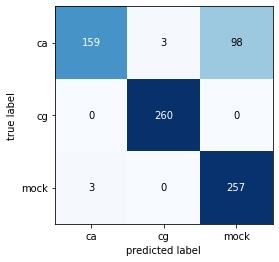

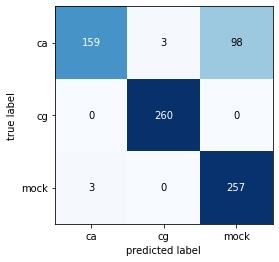

In [63]:
labels = ['ca','cg','mock']

matrix = confusion_matrix (test_labels,predicted)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3),labels, fontsize=10)
plt.yticks(range(3),labels, fontsize=10)